## Quantile Regression network on engineered features

- **Train the regression models on muons only**  
- **Test on testing portion of muons and all pions**  
- **No selection on momentum range**  
- **Only the in-time hits where delta <= 0.5 are included**

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pyarrow as pa
# import polars as pl
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import tqdm
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import mean_std_cross_val_scores

- **Regressors (Engineered features used for the models):**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points  

- **Target:**
    - `ring_radius_cal`: calculated ring radius based on the particle mass and track momentum

### 1.0 Read and process data

In [2]:
event_with_hit_features_path = 'data/events_with_hit_features_[cut_off_time=0.5].parquet'

In [3]:
df = pd.read_parquet(event_with_hit_features_path
                    ).dropna()

In [4]:
df_muons = df.query('label==0')

In [5]:
df_muons.shape

(2158635, 42)

In [6]:
df_muons.describe()

,composite_event_id,total_in_time_hits,x_aligned_min,x_aligned_max,x_aligned_width,y_aligned_min,y_aligned_max,y_aligned_width,hit_distance_min,hit_distance_max,...,ring_likelihood_muon,ring_likelihood_positron,ring_likelihood_kaon,ring_likelihood_background,label,first_hit,last_hit,total_hits,mass,ring_radius_cal
count,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,...,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2158635.0,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06,2.158635e+06
mean,1.026082e+15,1.714035e+01,-1.929751e+02,1.432334e+02,3.362086e+02,-1.868689e+02,1.581942e+02,3.450631e+02,1.507970e+02,2.195136e+02,...,8.887756e-01,1.661901e-01,4.455240e-04,5.526685e-03,0.0,4.410481e+07,4.410485e+07,4.148737e+01,1.056601e+02,1.805167e+02
std,9.001261e+14,5.754839e+00,3.468840e+01,5.513756e+01,6.401603e+01,3.742609e+01,4.615988e+01,6.021390e+01,2.241440e+01,2.931807e+01,...,2.620142e-01,3.180548e-01,2.039895e-02,7.398906e-02,0.0,2.602615e+07,2.602615e+07,2.274315e+01,0.000000e+00,1.145780e+01
min,1.285739e+12,3.000000e+00,-4.992225e+02,-2.845825e+02,4.899994e+00,-5.044576e+02,-3.803433e+02,5.279999e+00,4.684291e-01,4.993096e+01,...,1.216099e-37,1.216099e-37,1.216099e-37,1.216099e-37,0.0,0.000000e+00,2.000000e+01,5.000000e+00,1.056600e+02,8.215014e+00
25%,4.125031e+14,1.300000e+01,-2.108451e+02,1.165552e+02,3.060000e+02,-2.084747e+02,1.499109e+02,3.273500e+02,1.428338e+02,2.079562e+02,...,1.000000e+00,4.831920e-09,1.216099e-37,1.216099e-37,0.0,2.120522e+07,2.120530e+07,2.400000e+01,1.056600e+02,1.795201e+02
50%,8.336160e+14,1.700000e+01,-1.970281e+02,1.648931e+02,3.510000e+02,-1.930785e+02,1.738190e+02,3.585400e+02,1.533740e+02,2.181407e+02,...,1.000000e+00,1.002324e-03,1.216099e-37,1.216099e-37,0.0,4.387733e+07,4.387735e+07,3.700000e+01,1.056600e+02,1.840819e+02
75%,1.344889e+15,2.100000e+01,-1.808926e+02,1.813009e+02,3.780000e+02,-1.757001e+02,1.832392e+02,3.897100e+02,1.641873e+02,2.266251e+02,...,1.000000e+00,1.290363e-01,1.216099e-37,1.216099e-37,0.0,6.662182e+07,6.662186e+07,5.400000e+01,1.056600e+02,1.865573e+02
max,2.117348e+16,6.700000e+01,3.411062e+02,4.694849e+02,6.439000e+02,3.020579e+02,4.617254e+02,6.026600e+02,4.044119e+02,5.522397e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,8.962015e+07,8.962017e+07,3.790000e+02,1.056600e+02,1.890351e+02


In [7]:
train_df, test_df_muon = train_test_split(df_muons, 
                                          random_state=42)

In [8]:
test_df = pd.concat([test_df_muon, df.query('label==1')])

In [9]:
X_train_raw = train_df.iloc[:, 1:19]
y_train = train_df['ring_radius_cal']
X_test_raw = test_df.iloc[:, 1:19]
y_test = test_df['ring_radius_cal']

In [10]:
# Standardizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

### 2.0 Quantile Regression NN

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy().flatten(), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy().flatten(), dtype=torch.float32)

In [12]:
trainset = TensorDataset(X_train, y_train)

In [13]:
# split trainset to train and validation
train_size = int(0.6 * len(trainset)) # 60% of train data
val_size = len(trainset) - train_size

generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset=trainset, 
                                  lengths=[train_size, val_size],
                                  generator=generator1)

In [14]:
BATCH_SIZE = 1000 # adjust batch size later
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [16]:
# below code adopted from 
# https://www.kaggle.com/code/carlossouza/quantile-regression-pytorch-tabular-data-only
def quantile_loss(preds, target, quantile):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    
    errors = target - preds
    losses.append(torch.max((quantile - 1) * errors, quantile * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

In [17]:
# below code adopted from MDS DSCI 572 Lecture 5 notes
def trainer(model, optimizer, trainloader, validloader, epochs=5, patience=5, q=0.5, verbose=True):
    """Training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = quantile_loss(y_hat, y, quantile=q)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()       # Add loss for this batch to running total
            
        train_loss.append(train_batch_loss / len(trainloader))
            
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood

            for X_valid, y_valid in validloader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = quantile_loss(y_hat, y_valid, quantile=q) # Calculate loss based on output
                
                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))

        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_loss, valid_loss

In [18]:
# Define the model
model = torch.nn.Sequential(
    nn.Linear(18, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 12),
    nn.ReLU(),
    nn.Linear(12, 1)
)
model.to(device)

Sequential(
  (0): Linear(in_features=18, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=12, bias=True)
  (9): ReLU()
  (10): Linear(in_features=12, out_features=1, bias=True)
)

In [19]:
LEARNING_RATE = 0.0001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

**0.05 Quantile**

In [20]:
%%time
train_loss, valid_loss = trainer(model, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=10, 
                                 patience=5,
                                 q=0.05,
                                 verbose=True)

Epoch   1: Train Loss: 2.266. Valid Loss: 0.348.
Epoch   2: Train Loss: 0.313. Valid Loss: 0.299.
Epoch   3: Train Loss: 0.289. Valid Loss: 0.281.
Epoch   4: Train Loss: 0.280. Valid Loss: 0.280.
Epoch   5: Train Loss: 0.275. Valid Loss: 0.272.
Epoch   6: Train Loss: 0.270. Valid Loss: 0.269.
Epoch   7: Train Loss: 0.269. Valid Loss: 0.265.
Epoch   8: Train Loss: 0.265. Valid Loss: 0.276.
Epoch   9: Train Loss: 0.263. Valid Loss: 0.263.
Epoch  10: Train Loss: 0.262. Valid Loss: 0.274.
CPU times: user 1min 50s, sys: 10.6 s, total: 2min 1s
Wall time: 2min 46s


In [21]:
# notice that tensor on mps cannot be converted to numpy directly so using to('cpu')
test_result_qnn = test_df.copy()

In [22]:
# drop irrelevant cols to reduce size of file
test_result_qnn = test_result_qnn.drop(['run_id','burst_id','event_id','track_id',
                                       'chod_time','track_pos_x','track_pos_y',
                                       'ring_centre_pos_x','ring_centre_pos_y',
                                       'ring_likelihood_pion','ring_likelihood_muon','ring_likelihood_positron',
                                       'ring_likelihood_kaon','ring_likelihood_background',
                                       'first_hit','last_hit','total_hits','mass'], axis=1)

In [23]:
test_result_qnn['ring_radius_pred_q_0_05'] = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

**0.5 quantile**

In [24]:
%%time
train_loss, valid_loss = trainer(model, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=10, 
                                 patience=5,
                                 q=0.5,
                                 verbose=True)

Epoch   1: Train Loss: 0.929. Valid Loss: 0.896.
Epoch   2: Train Loss: 0.898. Valid Loss: 0.901.
Epoch   3: Train Loss: 0.888. Valid Loss: 0.895.
Epoch   4: Train Loss: 0.880. Valid Loss: 0.883.
Epoch   5: Train Loss: 0.873. Valid Loss: 0.871.
Epoch   6: Train Loss: 0.869. Valid Loss: 0.894.
Epoch   7: Train Loss: 0.863. Valid Loss: 0.861.
Epoch   8: Train Loss: 0.862. Valid Loss: 0.861.
Epoch   9: Train Loss: 0.858. Valid Loss: 0.885.
Epoch  10: Train Loss: 0.853. Valid Loss: 0.888.
CPU times: user 1min 51s, sys: 10.6 s, total: 2min 2s
Wall time: 2min 48s


In [25]:
test_result_qnn['ring_radius_pred_q_0_5'] = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

**0.95 quantile**

In [26]:
%%time
train_loss, valid_loss = trainer(model, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=10, 
                                 patience=5,
                                 q=0.95,
                                 verbose=True)

Epoch   1: Train Loss: 0.211. Valid Loss: 0.205.
Epoch   2: Train Loss: 0.206. Valid Loss: 0.209.
Epoch   3: Train Loss: 0.207. Valid Loss: 0.204.
Epoch   4: Train Loss: 0.207. Valid Loss: 0.211.
Epoch   5: Train Loss: 0.206. Valid Loss: 0.212.
Epoch   6: Train Loss: 0.205. Valid Loss: 0.211.
Epoch   7: Train Loss: 0.204. Valid Loss: 0.204.
Epoch   8: Train Loss: 0.203. Valid Loss: 0.200.
Epoch   9: Train Loss: 0.202. Valid Loss: 0.219.
Epoch  10: Train Loss: 0.203. Valid Loss: 0.201.
CPU times: user 1min 52s, sys: 10.6 s, total: 2min 2s
Wall time: 2min 48s


In [27]:
test_result_qnn['ring_radius_pred_q_0_95'] = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

**Result of predictions**

In [28]:
# drop irrelative columns for analysis purposes
test_result_qnn = test_result_qnn[['class',
                                   'track_momentum',
                                   'ring_radius',
                                   'ring_radius_cal',
                                   'ring_radius_pred_q_0_05',
                                   'ring_radius_pred_q_0_5',
                                   'ring_radius_pred_q_0_95',
                                  ]]

test_result_qnn

,class,track_momentum,ring_radius,ring_radius_cal,ring_radius_pred_q_0_05,ring_radius_pred_q_0_5,ring_radius_pred_q_0_95
1394664,muon,39.457001,187.011002,185.005157,184.271240,187.967484,189.244034
542241,muon,13.633293,139.788010,137.621536,140.458084,142.776520,148.403610
91278,muon,44.675533,186.774033,186.233276,182.341248,185.612320,187.627975
2068331,muon,37.054966,188.003036,184.253876,182.120010,186.573380,188.186783
1977295,muon,15.124091,153.194870,148.973877,147.344635,151.351700,156.037888
...,...,...,...,...,...,...,...
2376022,pion,31.104301,175.371704,174.585281,172.521393,175.903305,179.206131
2376023,pion,32.657063,178.343094,176.125702,176.679855,181.291504,184.256454
2376024,pion,19.860395,148.395798,148.410736,146.816162,149.921570,153.450394
2376025,pion,29.285913,175.335617,172.438187,169.097260,172.759964,176.334427


### 3.0 Analysis

In [29]:
test_result_qnn.describe()

,track_momentum,ring_radius,ring_radius_cal,ring_radius_pred_q_0_05,ring_radius_pred_q_0_5,ring_radius_pred_q_0_95
count,755306.000000,7.553060e+05,755306.000000,755306.000000,755306.000000,755306.000000
mean,36.143753,9.100708e+03,177.890335,174.683456,178.788269,182.006424
std,12.013361,1.485440e+06,13.031551,13.642350,12.857414,11.271275
min,9.442538,0.000000e+00,4.270976,4.330139,50.521950,67.423080
25%,27.424381,1.759059e+02,175.447456,171.827332,176.522152,180.688416
50%,35.071695,1.826612e+02,182.067879,179.139648,183.219551,186.155807
75%,43.918932,1.866670e+02,185.680462,182.813019,186.324875,188.130135
max,74.378830,1.124473e+09,188.987473,204.018082,207.180313,239.678482


In [30]:
test_result_qnn['diff_0_05_0_5'] = test_result_qnn['ring_radius_pred_q_0_5'] - test_result_qnn['ring_radius_pred_q_0_05']
test_result_qnn['diff_0_5_0_95'] = test_result_qnn['ring_radius_pred_q_0_95'] - test_result_qnn['ring_radius_pred_q_0_5']

In [31]:
test_result_qnn

,class,track_momentum,ring_radius,ring_radius_cal,ring_radius_pred_q_0_05,ring_radius_pred_q_0_5,ring_radius_pred_q_0_95,diff_0_05_0_5,diff_0_5_0_95
1394664,muon,39.457001,187.011002,185.005157,184.271240,187.967484,189.244034,3.696243,1.276550
542241,muon,13.633293,139.788010,137.621536,140.458084,142.776520,148.403610,2.318436,5.627090
91278,muon,44.675533,186.774033,186.233276,182.341248,185.612320,187.627975,3.271072,2.015656
2068331,muon,37.054966,188.003036,184.253876,182.120010,186.573380,188.186783,4.453369,1.613403
1977295,muon,15.124091,153.194870,148.973877,147.344635,151.351700,156.037888,4.007065,4.686188
...,...,...,...,...,...,...,...,...,...
2376022,pion,31.104301,175.371704,174.585281,172.521393,175.903305,179.206131,3.381912,3.302826
2376023,pion,32.657063,178.343094,176.125702,176.679855,181.291504,184.256454,4.611649,2.964951
2376024,pion,19.860395,148.395798,148.410736,146.816162,149.921570,153.450394,3.105408,3.528824
2376025,pion,29.285913,175.335617,172.438187,169.097260,172.759964,176.334427,3.662704,3.574463


Text(0.5, 1.0, 'Distribution of predicted ring radius difference between q=0.5 & q=0.05')

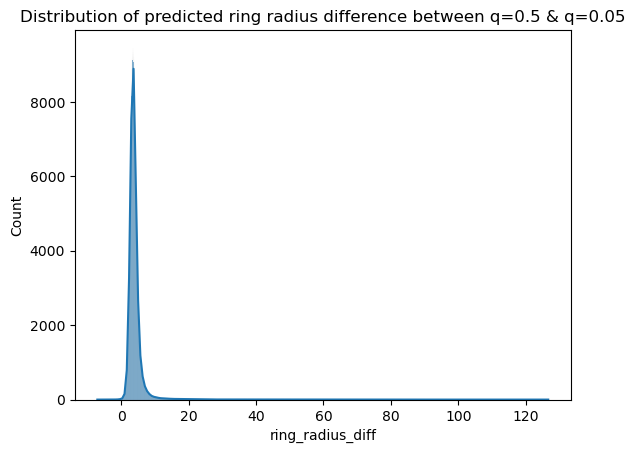

In [32]:
sns.histplot(data=test_result_qnn, x='diff_0_05_0_5', kde=True)

plt.xlabel('ring_radius_diff')
plt.title('Distribution of predicted ring radius difference between q=0.5 & q=0.05')

Text(0.5, 1.0, 'Distribution of predicted ring radius difference between q=0.95 & q=0.5')

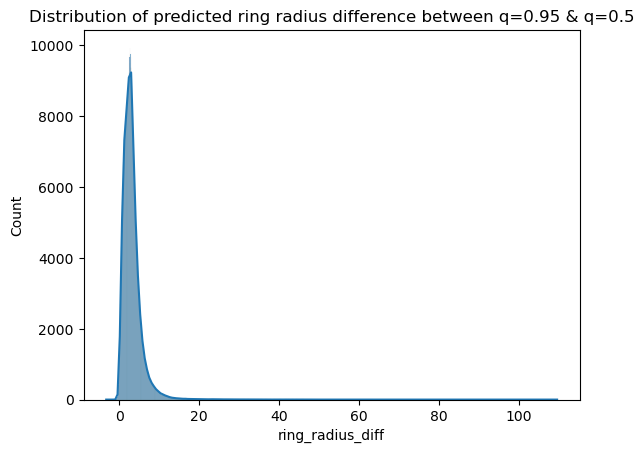

In [33]:
sns.histplot(data=test_result_qnn, x='diff_0_5_0_95', kde=True)

plt.xlabel('ring_radius_diff')
plt.title('Distribution of predicted ring radius difference between q=0.95 & q=0.5')

In [34]:
df_sort = test_result_qnn.sort_values(by='ring_radius_cal').reset_index()

In [35]:
df_sort['index']=df_sort.index

In [36]:
df_melted = df_sort.melt(id_vars='index',
                         value_vars=['ring_radius_pred_q_0_05',
                                     'ring_radius_pred_q_0_5',
                                     'ring_radius_pred_q_0_95',
                                     'ring_radius_cal'],
                         var_name='type',
                         value_name='ring_radius_value')
df_melted                                

,index,type,ring_radius_value
0,0,ring_radius_pred_q_0_05,39.468788
1,1,ring_radius_pred_q_0_05,75.347099
2,2,ring_radius_pred_q_0_05,65.706764
3,3,ring_radius_pred_q_0_05,128.754501
4,4,ring_radius_pred_q_0_05,76.794617
...,...,...,...
3021219,755301,ring_radius_cal,188.965698
3021220,755302,ring_radius_cal,188.971512
3021221,755303,ring_radius_cal,188.972672
3021222,755304,ring_radius_cal,188.976807


**Show three quantiles seperately on one plot**

<AxesSubplot: ylabel='ring_radius_value'>

/Users/pengzh/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/pengzh/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


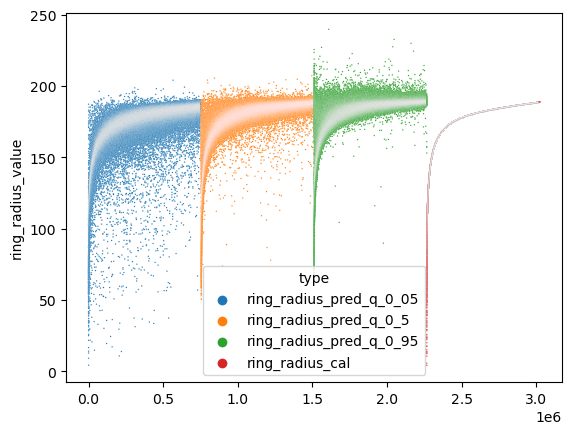

In [37]:
sns.scatterplot(data=df_melted, x = df_melted.index, y='ring_radius_value', hue='type', s=1)

**Plot stacked quantiles**

Text(0, 0.5, 'ring_radius')

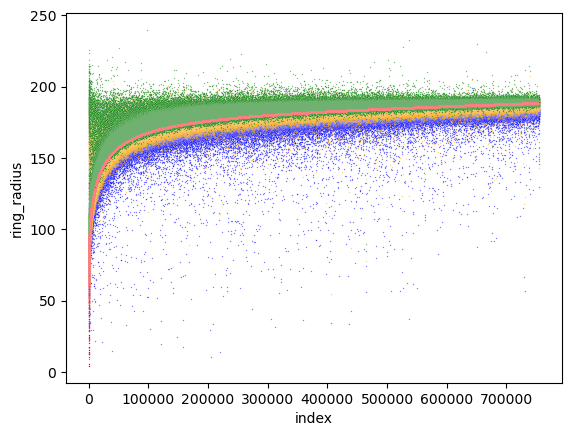

In [38]:
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_pred_q_0_05', color='blue', s=1, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_pred_q_0_5', color='orange', s=1, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_pred_q_0_95', color='green', s=1, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_cal', color='red', s=1)

plt.ylabel('ring_radius')

**Plot three quantiles seperately**

**0.05 quantile**

Text(0, 0.5, 'ring_radius')

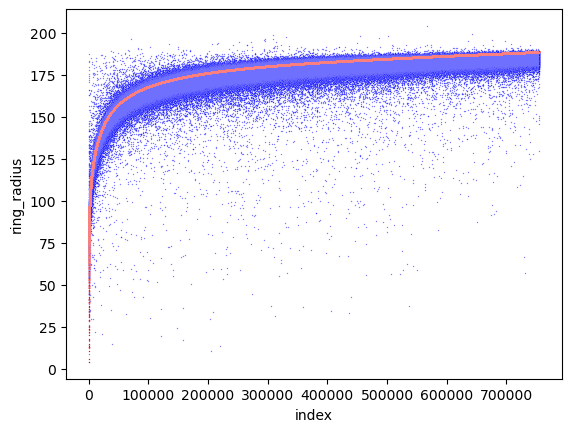

In [39]:
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_pred_q_0_05', color='blue', s=1, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_cal', color='red', s=1)

plt.ylabel('ring_radius')

**0.5 quantile**

Text(0, 0.5, 'ring_radius')

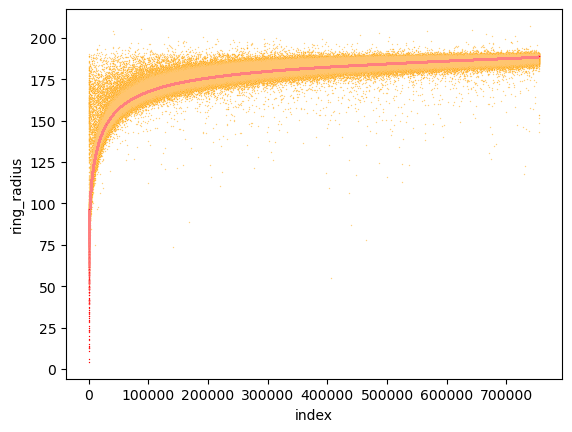

In [40]:
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_pred_q_0_5', color='orange', s=1, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_cal', color='red', s=1)

plt.ylabel('ring_radius')

**0.95 quantile**

Text(0, 0.5, 'ring_radius')

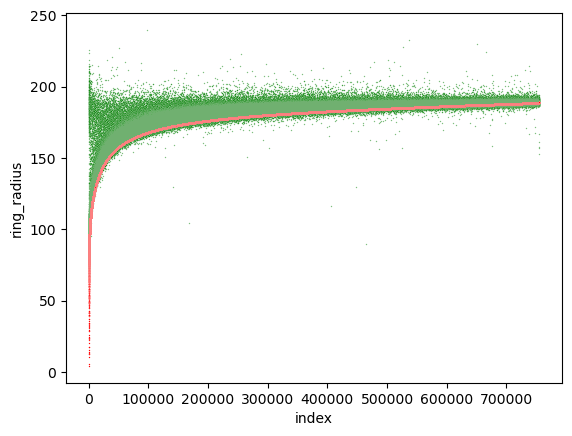

In [41]:
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_pred_q_0_95', color='green', s=1, alpha=0.5)
sns.scatterplot(data=df_sort, x = 'index', y='ring_radius_cal', color='red', s=1)

plt.ylabel('ring_radius')

In [42]:
test_result_qnn['track_momentum'].describe()

count    755306.000000
mean         36.143753
std          12.013361
min           9.442538
25%          27.424381
50%          35.071695
75%          43.918932
max          74.378830
Name: track_momentum, dtype: float64

In [43]:
bins = np.arange(9, 76, 1)
test_result_qnn['momentum_bin'] = pd.cut(test_result_qnn['track_momentum'], bins=bins)

In [49]:
# stat_pred_q_0_05 = pd.DataFrame(test_result_qnn.groupby(['momentum_bin', 'class']).aggregate({'ring_radius_pred_q_0_05': ['mean', 'std','min','max']}))
# stat_pred_q_0_05 = stat_pred_q_0_05.dropna()
# stat_pred_q_0_05 = stat_pred_q_0_05.reset_index()
# stat_pred_q_0_05.columns = ['momentum_bin', 'class', 'mean', 'std','min','max']

In [50]:
# stat_pred_q_0_5 = pd.DataFrame(test_result_qnn.groupby(['momentum_bin', 'class']).aggregate({'ring_radius_pred_q_0_5': ['mean', 'std','min','max']}))
# stat_pred_q_0_5 = stat_pred_q_0_5.dropna()
# stat_pred_q_0_5 = stat_pred_q_0_5.reset_index()
# stat_pred_q_0_5.columns = ['momentum_bin', 'class', 'mean', 'std','min','max']

In [51]:
# stat_pred_q_0_95 = pd.DataFrame(test_result_qnn.groupby(['momentum_bin', 'class']).aggregate({'ring_radius_pred_q_0_95': ['mean', 'std','min','max']}))
# stat_pred_q_0_95 = stat_pred_q_0_95.dropna()
# stat_pred_q_0_95 = stat_pred_q_0_95.reset_index()
# stat_pred_q_0_95.columns = ['momentum_bin', 'class', 'mean', 'std','min','max']

In [52]:
# stat_pred_q_0_05_muon = stat_pred_q_0_05.query('`class`=="muon"').reset_index()

# sns.lineplot(data=stat_pred_q_0_05_muon, x=stat_pred_q_0_05_muon.index, y='mean',label='Mean',marker='o')
# sns.lineplot(data=stat_pred_q_0_05_muon, x=stat_pred_q_0_05_muon.index, y='std', label='sd',marker='o')
# sns.lineplot(data=stat_pred_q_0_05_muon, x=stat_pred_q_0_05_muon.index, y='min', label='Min',marker='o')
# sns.lineplot(data=stat_pred_q_0_05_muon, x=stat_pred_q_0_05_muon.index, y='max', label='Max',marker='o')


# plt.ylabel('ring_radius_pred_q_0_05')
# plt.xlabel('index')
# plt.title('Stat of muons in each momentum bin (bin size = 1)')